Enhanced Iris Analysis System
Loading models...


c:\Users\dell\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Facial landmark predictor not found. Using basic eye detection.
Capturing image...
Looking for a high-quality image...
Could not capture high quality image. Best: 0.31
Analyzing iris...
Analyzing Left Eye...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Analyzing Right Eye...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


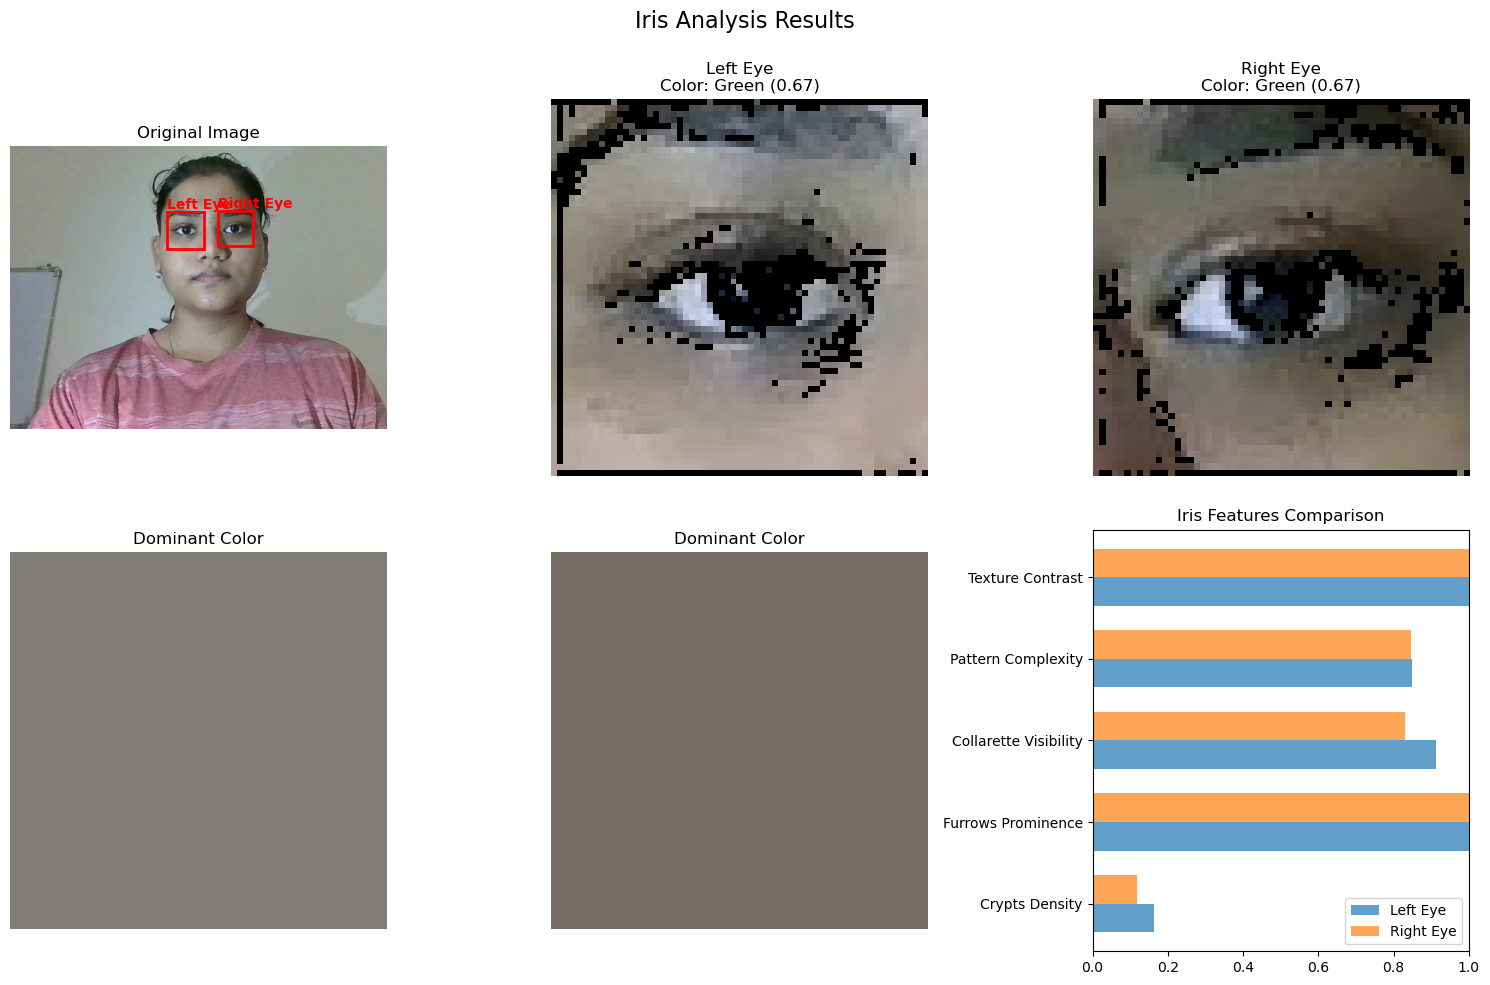


DETAILED ANALYSIS RESULTS

Left Eye:
  Color: Green (confidence: 0.67)
  Image Quality: 1.00
  Features:
    - Crypts Density: 0.16
    - Furrows Prominence: 5.21
    - Collarette Visibility: 0.91
    - Pattern Complexity: 0.85
    - Texture Contrast: 32.17

Right Eye:
  Color: Green (confidence: 0.67)
  Image Quality: 1.00
  Features:
    - Crypts Density: 0.12
    - Furrows Prominence: 4.48
    - Collarette Visibility: 0.83
    - Pattern Complexity: 0.85
    - Texture Contrast: 30.06

Analysis complete!


In [9]:
 # enhanced_iris_analysis.py
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.preprocessing import image
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from collections import Counter
import dlib
import os
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Create directories for models and data if they don't exist
os.makedirs('models', exist_ok=True)
os.makedirs('data', exist_ok=True)

# Improved iris segmentation model (U-Net architecture)
def create_iris_segmentation_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    
    # Downsample path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bottom
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    
    # Upsample path
    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
    
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
    
    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile models (in a real scenario, you would load pre-trained models)
def load_or_create_models():
    # Create iris segmentation model
    segmentation_model = create_iris_segmentation_model()
    segmentation_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Create color classification model (simplified CNN)
    color_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')  # 5 color classes
    ])
    color_model.compile(optimizer='adam', 
                       loss='sparse_categorical_crossentropy', 
                       metrics=['accuracy'])
    
    # Load face detector
    detector = dlib.get_frontal_face_detector()
    
    # Load facial landmark predictor
    try:
        predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")
    except:
        print("Facial landmark predictor not found. Using basic eye detection.")
        predictor = None
        
    return segmentation_model, color_model, detector, predictor

# Enhanced image preprocessing
def preprocess_image(img, target_size=(128, 128)):
    # Resize image
    img = cv2.resize(img, target_size)
    
    # Normalize pixel values
    img = img.astype('float32') / 255.0
    
    # Apply histogram equalization to enhance contrast
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist((img_yuv[:,:,0] * 255).astype('uint8')) / 255.0
    img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    
    return img

# Enhanced iris segmentation using U-Net
def segment_iris(image, model):
    # Preprocess image
    input_img = preprocess_image(image)
    input_img = np.expand_dims(input_img, axis=0)
    
    # Predict segmentation mask
    mask = model.predict(input_img)[0]
    
    # Threshold mask to binary
    mask = (mask > 0.5).astype('uint8')
    
    return mask

# Enhanced eye detection with fallback
def detect_eyes(image, detector, predictor):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Try to use facial landmarks for precise eye detection
    if predictor is not None:
        faces = detector(gray)
        if len(faces) > 0:
            face = faces[0]
            landmarks = predictor(gray, face)
            
            # Left eye landmarks (points 36 to 41)
            left_eye_points = []
            for n in range(36, 42):
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                left_eye_points.append((x, y))
            
            # Right eye landmarks (points 42 to 47)
            right_eye_points = []
            for n in range(42, 48):
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                right_eye_points.append((x, y))
            
            return left_eye_points, right_eye_points
    
    # Fallback: Use Haar cascades for eye detection
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    eyes = eye_cascade.detectMultiScale(gray, 1.3, 5)
    
    if len(eyes) >= 2:
        # Sort eyes by x-position and assume left and right eyes
        eyes = sorted(eyes, key=lambda x: x[0])
        left_eye = eyes[0]
        right_eye = eyes[1]
        
        # Convert to points format
        lx, ly, lw, lh = left_eye
        left_eye_points = [(lx, ly), (lx+lw, ly), (lx+lw, ly+lh), (lx, ly+lh)]
        
        rx, ry, rw, rh = right_eye
        right_eye_points = [(rx, ry), (rx+rw, ry), (rx+rw, ry+rh), (rx, ry+rh)]
        
        return left_eye_points, right_eye_points
    
    # Final fallback: Use image quarters as eye regions
    height, width = image.shape[:2]
    left_eye_points = [(width//4, height//3), (width//2, height//3), 
                       (width//2, 2*height//3), (width//4, 2*height//3)]
    right_eye_points = [(width//2, height//3), (3*width//4, height//3), 
                        (3*width//4, 2*height//3), (width//2, 2*height//3)]
    
    return left_eye_points, right_eye_points

# Enhanced iris extraction with segmentation
def extract_iris_region(image, eye_points, segmentation_model):
    # Get bounding box of the eye
    x_coords = [p[0] for p in eye_points]
    y_coords = [p[1] for p in eye_points]
    x, y = min(x_coords), min(y_coords)
    w, h = max(x_coords) - x, max(y_coords) - y
    
    # Expand the region slightly
    expand = 5
    x = max(0, x - expand)
    y = max(0, y - expand)
    w = min(image.shape[1] - x, w + 2*expand)
    h = min(image.shape[0] - y, h + 2*expand)
    
    # Extract the eye region
    eye_region = image[y:y+h, x:x+w]
    
    # Segment iris within the eye region
    iris_mask = segment_iris(eye_region, segmentation_model)
    
    # Apply mask to extract only iris pixels
    iris_mask = cv2.resize(iris_mask, (w, h))
    iris_mask = np.expand_dims(iris_mask, axis=-1)
    iris_region = eye_region * iris_mask
    
    return iris_region, iris_mask, (x, y, w, h)

def extract_color_features(iris_region):
    """
    Extract multiple color features from the iris region
    """
    if iris_region is None or iris_region.size == 0:
        return None
    
    # Convert to different color spaces
    hsv = cv2.cvtColor(iris_region, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(iris_region, cv2.COLOR_RGB2LAB)
    yuv = cv2.cvtColor(iris_region, cv2.COLOR_RGB2YUV)
    
    # Remove black pixels (background)
    mask = np.any(iris_region > [10, 10, 10], axis=-1)
    iris_pixels = iris_region[mask]
    
    if len(iris_pixels) == 0:
        return None
    
    features = {}
    
    # Basic color statistics
    features['mean_rgb'] = np.mean(iris_pixels, axis=0)
    features['std_rgb'] = np.std(iris_pixels, axis=0)
    features['median_rgb'] = np.median(iris_pixels, axis=0)
    
    # HSV statistics
    hsv_pixels = hsv[mask]
    features['mean_hsv'] = np.mean(hsv_pixels, axis=0)
    features['std_hsv'] = np.std(hsv_pixels, axis=0)
    
    # LAB statistics
    lab_pixels = lab[mask]
    features['mean_lab'] = np.mean(lab_pixels, axis=0)
    features['std_lab'] = np.std(lab_pixels, axis=0)
    
    # Color distribution features
    features['hue_std'] = np.std(hsv_pixels[:, 0])  # Hue variation
    features['saturation_mean'] = np.mean(hsv_pixels[:, 1])  # Average saturation
    features['value_mean'] = np.mean(hsv_pixels[:, 2])  # Average brightness
    
    # Dominant colors using K-means
    kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
    kmeans.fit(iris_pixels)
    features['dominant_colors'] = kmeans.cluster_centers_
    features['color_distribution'] = np.bincount(kmeans.labels_) / len(kmeans.labels_)
    
    # Color diversity (number of unique colors)
    unique_colors = len(np.unique(iris_pixels, axis=0))
    features['color_diversity'] = unique_colors / len(iris_pixels) if len(iris_pixels) > 0 else 0
    
    return features

def rule_based_color_classification(color_features):
    """
    Rule-based color classification using extracted features
    """
    mean_hsv = color_features['mean_hsv']
    std_hsv = color_features['std_hsv']
    mean_lab = color_features['mean_lab']
    
    hue = mean_hsv[0]
    saturation = mean_hsv[1]
    value = mean_hsv[2]
    lightness = mean_lab[0]
    
    # Rule-based classification
    if hue < 15 and saturation > 40:
        return 0  # Brown
    elif hue < 35 and saturation > 30:
        return 2  # Green (often classified as hazel in rule-based)
    elif hue < 85:
        return 2  # Green
    elif lightness > 70 and saturation < 40:
        return 4  # Gray
    elif hue >= 85 and saturation > 30:
        return 1  # Blue
    else:
        return 3  # Hazel (default)

def feature_based_color_classification(color_features):
    """
    Simple feature-based classification (would be replaced with a trained model)
    """
    # This is a simplified version - in practice, you would train a classifier
    # on extracted color features
    
    # Use dominant hue as primary indicator
    dominant_hue = color_features['dominant_colors'][0]
    hsv_dominant = cv2.cvtColor(np.uint8([[dominant_hue]]), cv2.COLOR_RGB2HSV)[0][0]
    hue = hsv_dominant[0]
    
    if hue < 15:
        return 0  # Brown
    elif hue < 35:
        return 2  # Green
    elif hue < 85:
        return 2  # Green
    elif hue >= 85:
        return 1  # Blue
    else:
        return 3  # Hazel

def verify_color_with_features(color_name, color_features):
    """
    Verify color classification using extracted features
    """
    mean_hsv = color_features['mean_hsv']
    std_hsv = color_features['std_hsv']
    
    hue = mean_hsv[0]
    saturation = mean_hsv[1]
    value = mean_hsv[2]
    hue_std = std_hsv[0]
    
    # Green iris characteristics:
    # - Medium hue (typically 30-85)
    # - Moderate to high saturation
    # - Moderate value (not too dark, not too light)
    # - Moderate hue variation
    
    if color_name == "Green":
        # Verify if it matches green iris characteristics
        if not (30 <= hue <= 85 and saturation > 40 and 50 <= value <= 180 and hue_std < 30):
            # Doesn't match typical green iris, likely hazel
            return "Hazel"
    
    elif color_name == "Blue":
        # Blue iris characteristics:
        # - High hue (typically 85-120)
        # - Moderate saturation
        # - High value (light)
        if not (85 <= hue <= 120 and saturation > 30 and value > 100):
            # Doesn't match typical blue iris, likely gray
            return "Gray"
    
    elif color_name == "Brown":
        # Brown iris characteristics:
        # - Low hue (typically 0-15)
        # - High saturation
        # - Low to medium value
        if not (hue < 20 and saturation > 50 and value < 150):
            # Doesn't match typical brown iris
            return "Hazel"  # Could be dark hazel
    
    return color_name  # No change needed

def enhanced_iris_color_analysis(iris_region, color_model):
    """
    Enhanced color analysis with multiple verification steps
    """
    # First pass classification using CNN
    iris_resized = cv2.resize(iris_region, (64, 64))
    iris_normalized = iris_resized.astype('float32') / 255.0
    
    # Color classes
    color_classes = ['Brown', 'Blue', 'Green', 'Hazel', 'Gray']
    
    # CNN prediction
    cnn_predictions = color_model.predict(np.expand_dims(iris_normalized, axis=0))[0]
    cnn_prediction = np.argmax(cnn_predictions)
    cnn_confidence = cnn_predictions[cnn_prediction]
    color_name = color_classes[cnn_prediction]
    
    # Get additional features for verification
    color_features = extract_color_features(iris_region)
    
    if color_features is None:
        return color_name, cnn_confidence, color_features['dominant_colors'][0] if 'dominant_colors' in color_features else [0, 0, 0]
    
    # Rule-based classification
    rule_based_prediction = rule_based_color_classification(color_features)
    
    # Feature-based classification
    feature_based_prediction = feature_based_color_classification(color_features)
    
    # Combine predictions (simple voting)
    predictions = [cnn_prediction, rule_based_prediction, feature_based_prediction]
    final_prediction = Counter(predictions).most_common(1)[0][0]
    color_name = color_classes[final_prediction]
    
    # Calculate confidence based on agreement
    confidence = min(0.99, sum(1 for p in predictions if p == final_prediction) / len(predictions))
    
    # If confidence is low, perform additional verification
    if confidence < 0.6:
        # Check against known color patterns
        verified_color = verify_color_with_features(color_name, color_features)
        
        if verified_color != color_name:
            print(f"Color verification changed from {color_name} to {verified_color}")
            color_name = verified_color
            confidence = 0.7  # Moderate confidence after verification
    
    # Get dominant color for visualization
    dominant_color = color_features['dominant_colors'][0] if 'dominant_colors' in color_features else [0, 0, 0]
    
    return color_name, confidence, dominant_color

# Enhanced feature extraction
def extract_iris_features(iris_region, iris_mask):
    # Convert to grayscale for texture analysis
    iris_gray = cv2.cvtColor(iris_region, cv2.COLOR_RGB2GRAY)
    
    # Remove background (black pixels)
    iris_pixels = iris_gray[iris_mask[:, :, 0] > 0]
    
    if len(iris_pixels) == 0:
        return {
            "crypts_density": 0,
            "furrows_prominence": 0,
            "collarette_visibility": 0,
            "pattern_complexity": 0,
            "texture_contrast": 0
        }
    
    # Calculate texture features
    texture_contrast = np.std(iris_pixels) if len(iris_pixels) > 0 else 0
    
    # Use Sobel operator to detect edges (furrows)
    sobelx = cv2.Sobel(iris_gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(iris_gray, cv2.CV_64F, 0, 1, ksize=5)
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    furrows_prominence = np.mean(gradient_magnitude[iris_mask[:, :, 0] > 0]) / 255.0
    
    # Use Laplacian to detect fine details (crypts)
    laplacian = cv2.Laplacian(iris_gray, cv2.CV_64F)
    crypts_density = np.mean(np.abs(laplacian[iris_mask[:, :, 0] > 0])) / 255.0
    
    # Estimate collarette visibility (darker region around pupil)
    _, binary = cv2.threshold(iris_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    collarette_visibility = np.mean(binary[iris_mask[:, :, 0] > 0]) / 255.0
    
    # Pattern complexity (entropy)
    hist = cv2.calcHist([iris_gray], [0], iris_mask[:, :, 0], [256], [0, 256])
    hist = hist / hist.sum() if hist.sum() > 0 else hist
    entropy = -np.sum([p * np.log2(p + 1e-10) for p in hist if p > 0])
    pattern_complexity = entropy / 8.0  # Normalize (max entropy for 8-bit image is 8)
    
    return {
        "crypts_density": float(crypts_density),
        "furrows_prominence": float(furrows_prominence),
        "collarette_visibility": float(collarette_visibility),
        "pattern_complexity": float(pattern_complexity),
        "texture_contrast": float(texture_contrast)
    }

# Image quality assessment
def assess_image_quality(iris_region, iris_mask):
    if iris_region is None or np.sum(iris_mask) == 0:
        return 0.0
    
    # Calculate focus measure (variance of Laplacian)
    gray = cv2.cvtColor(iris_region, cv2.COLOR_RGB2GRAY)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    
    # Calculate contrast
    contrast = np.std(gray[iris_mask[:, :, 0] > 0]) if np.any(iris_mask > 0) else 0
    
    # Calculate brightness (should be in middle range)
    brightness = np.mean(gray[iris_mask[:, :, 0] > 0]) if np.any(iris_mask > 0) else 0
    brightness_score = 1 - abs(brightness - 127) / 127
    
    # Calculate iris coverage (percentage of non-zero pixels in mask)
    coverage = np.mean(iris_mask)
    
    # Combine scores (weights can be adjusted)
    quality_score = (fm * 0.3 + contrast * 0.2 + brightness_score * 0.2 + coverage * 0.3) / 100
    
    return min(1.0, max(0.0, quality_score))

# Capture image from webcam with quality check
def capture_high_quality_image(min_quality=0.5, max_attempts=5):
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Cannot access webcam")
        return None
    
    print("Looking for a high-quality image...")
    best_image = None
    best_quality = 0
    
    for attempt in range(max_attempts):
        ret, frame = cap.read()
        if not ret:
            continue
            
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Quick quality assessment (simplified)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        fm = cv2.Laplacian(gray, cv2.CV_64F).var()
        quality = min(1.0, fm / 1000)  # Simple quality measure
        
        if quality > best_quality:
            best_quality = quality
            best_image = rgb_frame
            
        # Display preview with quality info
        preview = frame.copy()
        cv2.putText(preview, f"Quality: {quality:.2f}", (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(preview, f"Attempt: {attempt+1}/{max_attempts}", (10, 60), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.imshow('Webcam - Looking for high quality image', preview)
        
        if cv2.waitKey(500) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()
    
    if best_quality >= min_quality:
        print(f"Captured image with quality: {best_quality:.2f}")
        return best_image
    else:
        print(f"Could not capture high quality image. Best: {best_quality:.2f}")
        return best_image  # Return the best we have anyway

# Main analysis function
def analyze_iris(image, segmentation_model, color_model, detector, predictor):
    results = {}
    
    # Detect eyes
    left_eye_points, right_eye_points = detect_eyes(image, detector, predictor)
    
    # Analyze both eyes
    for eye_name, eye_points in [("Left Eye", left_eye_points), ("Right Eye", right_eye_points)]:
        print(f"Analyzing {eye_name}...")
        
        # Extract iris region with segmentation
        iris_region, iris_mask, bbox = extract_iris_region(image, eye_points, segmentation_model)
        
        # Assess image quality
        quality_score = assess_image_quality(iris_region, iris_mask)
        
        if quality_score < 0.3:
            print(f"  Low quality image for {eye_name}. Skipping detailed analysis.")
            results[eye_name] = {
                "quality_score": quality_score,
                "error": "Low quality image"
            }
            continue
        
        # Classify color with enhanced analysis
        color_name, color_confidence, dominant_color = enhanced_iris_color_analysis(iris_region, color_model)
        
        # Extract features
        features = extract_iris_features(iris_region, iris_mask)
        
        # Store results
        results[eye_name] = {
            "iris_region": iris_region,
            "iris_mask": iris_mask,
            "bbox": bbox,
            "color": color_name,
            "color_confidence": color_confidence,
            "dominant_color": dominant_color,
            "features": features,
            "quality_score": quality_score
        }
    
    return results

# Visualization function
def visualize_results(image, results):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle("Iris Analysis Results", fontsize=16)
    
    # Display original image with eye bounding boxes
    axes[0, 0].imshow(image)
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis('off')
    
    # Draw bounding boxes on original image
    for eye_name, result in results.items():
        if "bbox" in result:
            x, y, w, h = result["bbox"]
            rect = Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
            axes[0, 0].add_patch(rect)
            axes[0, 0].text(x, y-5, eye_name, color='red', fontweight='bold')
    
    # Plot results for each eye
    for idx, (eye_name, result) in enumerate(results.items()):
        if "error" in result:
            axes[0, 1+idx].text(0.5, 0.5, f"{eye_name}\n{result['error']}", 
                               ha='center', va='center', transform=axes[0, 1+idx].transAxes)
            axes[0, 1+idx].set_title(eye_name)
            axes[0, 1+idx].axis('off')
            continue
            
        # Display iris region
        axes[0, 1+idx].imshow(result["iris_region"])
        axes[0, 1+idx].set_title(f"{eye_name}\nColor: {result['color']} ({result['color_confidence']:.2f})")
        axes[0, 1+idx].axis('off')
        
        # Display color swatch
        color_swatch = np.zeros((50, 50, 3), dtype=np.uint8)
        color_swatch[:, :] = result["dominant_color"].astype(int)
        axes[1, idx].imshow(color_swatch)
        axes[1, idx].set_title("Dominant Color")
        axes[1, idx].axis('off')
    
    # Display features as bar chart for both eyes
    if len(results) > 0:
        feature_names = []
        feature_values_left = []
        feature_values_right = []
        
        # Get feature names from the first available result
        for eye_name, result in results.items():
            if "features" in result:
                feature_names = list(result["features"].keys())
                break
        
        # Get feature values for each eye
        for feature in feature_names:
            if "Left Eye" in results and "features" in results["Left Eye"]:
                feature_values_left.append(results["Left Eye"]["features"].get(feature, 0))
            else:
                feature_values_left.append(0)
                
            if "Right Eye" in results and "features" in results["Right Eye"]:
                feature_values_right.append(results["Right Eye"]["features"].get(feature, 0))
            else:
                feature_values_right.append(0)
        
        # Plot both eyes' features
        x_pos = np.arange(len(feature_names))
        bar_width = 0.35
        
        axes[1, 2].barh(x_pos - bar_width/2, feature_values_left, bar_width, 
                       alpha=0.7, label='Left Eye')
        axes[1, 2].barh(x_pos + bar_width/2, feature_values_right, bar_width, 
                       alpha=0.7, label='Right Eye')
        
        axes[1, 2].set_yticks(x_pos)
        axes[1, 2].set_yticklabels([f.replace('_', ' ').title() for f in feature_names])
        axes[1, 2].set_xlim(0, 1)
        axes[1, 2].set_title("Iris Features Comparison")
        axes[1, 2].legend()
    
    # Remove empty subplots
    if len(results) < 2:
        for i in range(1+len(results), 3):
            fig.delaxes(axes[0, i])
            fig.delaxes(axes[1, i])
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\n" + "="*60)
    print("DETAILED ANALYSIS RESULTS")
    print("="*60)
    
    for eye_name, result in results.items():
        print(f"\n{eye_name}:")
        if "error" in result:
            print(f"  Error: {result['error']}")
            continue
            
        print(f"  Color: {result['color']} (confidence: {result['color_confidence']:.2f})")
        print(f"  Image Quality: {result['quality_score']:.2f}")
        print("  Features:")
        for feature, value in result['features'].items():
            print(f"    - {feature.replace('_', ' ').title()}: {value:.2f}")

# Main function
def main():
    print("Enhanced Iris Analysis System")
    print("=============================")
    
    # Load or create models
    print("Loading models...")
    segmentation_model, color_model, detector, predictor = load_or_create_models()
    
    # Capture image
    print("Capturing image...")
    image = capture_high_quality_image()
    
    if image is None:
        print("Failed to capture image. Exiting.")
        return
    
    # Analyze iris
    print("Analyzing iris...")
    results = analyze_iris(image, segmentation_model, color_model, detector, predictor)
    
    # Visualize results
    visualize_results(image, results)
    
    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()